In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "yourpath/data_stream-oper_stepType-instant.nc"
ds = xr.open_dataset(file_path)


In [ ]:
variables = ['z','t','u','v','q']
level = 0
time_window = 40
target_variable = 'z'
selected_year = 2020

ds_year = ds.sel(valid_time=ds.valid_time.where(ds.valid_time.dt.year == selected_year, drop=True))

T_total = len(ds_year.valid_time)
H = len(ds_year.latitude)
W = len(ds_year.longitude)
C = len(variables)

print(f"Total time steps: {T_total}, Height: {H}, Width: {W}, Channels: {C}")

Total time steps: 368, Height: 201, Width: 281, Channels: 5


In [ ]:
import numpy as np

x_path = 'yourpath/X_full_(z,t,u,v,q).npy'
x = np.load(x_path)
print(x.shape)

(328, 40, 5, 201, 281)


In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np

class ERA5LazyDataset(Dataset):
    def __init__(self, x_file, y_file, start_idx=0, end_idx=None):
        self.x_file = x_file
        self.y_file = y_file
        self.x_data = np.load(x_file, mmap_mode='r')
        self.y_data = np.load(y_file, mmap_mode='r')
        self.g = 9.80665

        self.variables = ['z', 't', 'u', 'v', 'q']

        self.norm_dict = {
            'z': (5880, 100),
            't': (270, 15),
            'u': (0.0, 20.0),
            'v': (0.0, 20.0),
            'q': (0.005, 0.003),
        }


        self.start_idx = start_idx
        self.end_idx = end_idx if end_idx is not None else self.x_data.shape[0]
        assert 0 <= self.start_idx < self.end_idx <= self.x_data.shape[0]

        self.length = self.end_idx - self.start_idx

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        real_idx = self.start_idx + idx


        x = self.x_data[real_idx].copy()
        y = self.y_data[real_idx].copy()


        x[:, 0, :, :] = x[:, 0, :, :] / self.g
        y = y / self.g


        for i, var in enumerate(self.variables):
            mean, std = self.norm_dict[var]
            x[:, i, :, :] = (x[:, i, :, :] - mean) / std


        y = (y - self.norm_dict['z'][0]) / self.norm_dict['z'][1]


        x_tensor = torch.tensor(x, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0)

        return x_tensor, y_tensor


In [ ]:
x_file = "yourpath/X_full_(z,t,u,v,q).npy"
y_file = "yourpath/y_full_(z,t,u,v,q).npy"

total_len = np.load(x_file, mmap_mode='r').shape[0]
split_idx = int(total_len * 0.8)

train_dataset = ERA5LazyDataset(x_file, y_file, start_idx=0, end_idx=split_idx)
val_dataset = ERA5LazyDataset(x_file, y_file, start_idx=split_idx, end_idx=total_len)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)


x_batch, y_batch = next(iter(train_loader))
print("x shape:", x_batch.shape)
print("y shape:", y_batch.shape)


x shape: torch.Size([5, 40, 5, 201, 281])
y shape: torch.Size([5, 1, 201, 281])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:

X_train = np.random.rand(40, 10, 5, 201, 281).astype(np.float32)
y_train = np.random.rand(40, 201, 281).astype(np.float32)
X_val = np.random.rand(10, 10, 5, 201, 281).astype(np.float32)
y_val = np.random.rand(10, 201, 281).astype(np.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).to(device)
y_train_tensor = torch.tensor(y_train).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(X_val).to(device)
y_val_tensor = torch.tensor(y_val).unsqueeze(1).to(device)

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super().__init__()
        padding = kernel_size // 2
        self.hidden_channels = hidden_channels
        self.conv = nn.Conv2d(input_channels + hidden_channels,
                              4 * hidden_channels,
                              kernel_size,
                              padding=padding,
                              bias=bias)

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        conv_out = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_out, self.hidden_channels, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next


In [ ]:
class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_channels = hidden_channels if isinstance(hidden_channels, list) else [hidden_channels]*num_layers
        self.cells = nn.ModuleList()
        for i in range(num_layers):
            in_channels = input_channels if i == 0 else self.hidden_channels[i-1]
            self.cells.append(ConvLSTMCell(in_channels, self.hidden_channels[i], kernel_size))

    def forward(self, x):
        N, T, C, H, W = x.size()
        h = [torch.zeros(N, self.hidden_channels[i], H, W, device=x.device) for i in range(self.num_layers)]
        c = [torch.zeros(N, self.hidden_channels[i], H, W, device=x.device) for i in range(self.num_layers)]

        outputs = []
        for t in range(T):
            input_t = x[:, t]
            for i, cell in enumerate(self.cells):
                h[i], c[i] = cell(input_t, h[i], c[i])
                input_t = h[i]
            outputs.append(h[-1])

        out = torch.stack(outputs, dim=1)
        return out, (h, c)


In [ ]:
class ConvLSTMWithCorrection(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super().__init__()
        self.input_channels = input_channels
        self.convlstm = ConvLSTM(input_channels + 1, hidden_channels, kernel_size)
        self.conv_out = nn.Conv2d(hidden_channels, 1, kernel_size=1)

        self.correction = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=1)
        )


    def forward(self, x):

        u = x[:, :, 2]
        v = x[:, :, 3]


        wind_speed = torch.sqrt(u**2 + v**2 + 1e-6)
        wind_speed = wind_speed.unsqueeze(2)

        x_aug = torch.cat([x, wind_speed], dim=2)

        out, _ = self.convlstm(x_aug)
        last_out = out[:, -1]
        y_pred = self.conv_out(last_out)

        residual = self.correction(y_pred)
        y_final = y_pred + residual

        return y_final


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

input_channels = 5
model = ConvLSTMWithCorrection(input_channels=input_channels,
                               hidden_channels=16,
                               kernel_size=5).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)

Device: cuda


In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime

num_epochs = 10
batch_size = 4

train_losses = []
val_losses = []

pred_list = []
actual_list = []
error_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for x, y in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

[Epoch 1/10] Training: 100%|██████████| 53/53 [01:42<00:00,  1.93s/it]


Epoch 1 - Train Loss: 0.0130, Val Loss: 0.0125


[Epoch 2/10] Training: 100%|██████████| 53/53 [01:42<00:00,  1.93s/it]


Epoch 2 - Train Loss: 0.0111, Val Loss: 0.0119


[Epoch 3/10] Training: 100%|██████████| 53/53 [01:42<00:00,  1.93s/it]


Epoch 3 - Train Loss: 0.0107, Val Loss: 0.0141


[Epoch 4/10] Training: 100%|██████████| 53/53 [01:42<00:00,  1.93s/it]


Epoch 4 - Train Loss: 0.0115, Val Loss: 0.0155


[Epoch 5/10] Training: 100%|██████████| 53/53 [01:42<00:00,  1.93s/it]


Epoch 5 - Train Loss: 0.0117, Val Loss: 0.0249


[Epoch 6/10] Training: 100%|██████████| 53/53 [01:42<00:00,  1.93s/it]


Epoch 6 - Train Loss: 0.0108, Val Loss: 0.0105


[Epoch 7/10] Training: 100%|██████████| 53/53 [01:41<00:00,  1.92s/it]


Epoch 7 - Train Loss: 0.0094, Val Loss: 0.0125


[Epoch 8/10] Training: 100%|██████████| 53/53 [01:41<00:00,  1.92s/it]


Epoch 8 - Train Loss: 0.0117, Val Loss: 0.0167


[Epoch 9/10] Training: 100%|██████████| 53/53 [01:42<00:00,  1.92s/it]


Epoch 9 - Train Loss: 0.0140, Val Loss: 0.0106


[Epoch 10/10] Training: 100%|██████████| 53/53 [01:42<00:00,  1.93s/it]


Epoch 10 - Train Loss: 0.0084, Val Loss: 0.0096


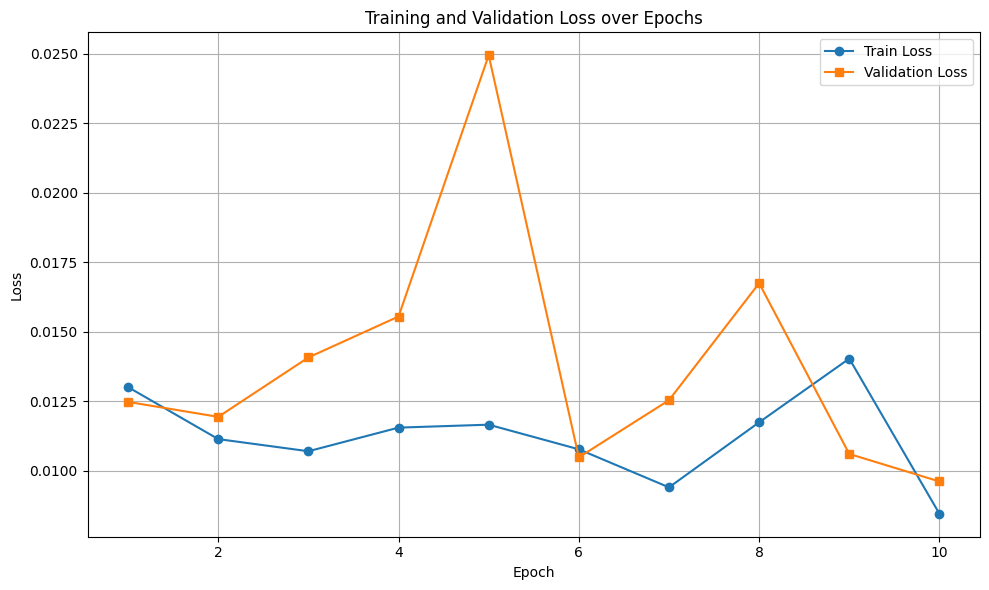

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
pred_list = []
actual_list = []
error_list = []

model.eval()

with torch.no_grad():
    for i in tqdm(range(len(val_loader.dataset))):
        x_sample = val_dataset[i][0].unsqueeze(0).to(device)
        y_true = val_dataset[i][1][0].cpu().numpy()

        y_pred_norm = model(x_sample).cpu().numpy()[0, 0]

        z_mean, z_std = 5880, 100
        pred_height = y_pred_norm * z_std + z_mean
        actual_height = y_true * z_std + z_mean
        abs_error = np.abs(pred_height - actual_height)

        pred_list.append(pred_height)
        actual_list.append(actual_height)
        error_list.append(abs_error)


100%|██████████| 66/66 [00:11<00:00,  5.51it/s]


In [ ]:
file_path = 'yourpath'

valid_time_file = os.path.join(file_path, 'valid_times_full_(z,t,u,v,q).npy')
val_time_raw = np.load(valid_time_file)

print(f"총 valid_time 수: {len(val_time_raw)}")


총 valid_time 수: 328


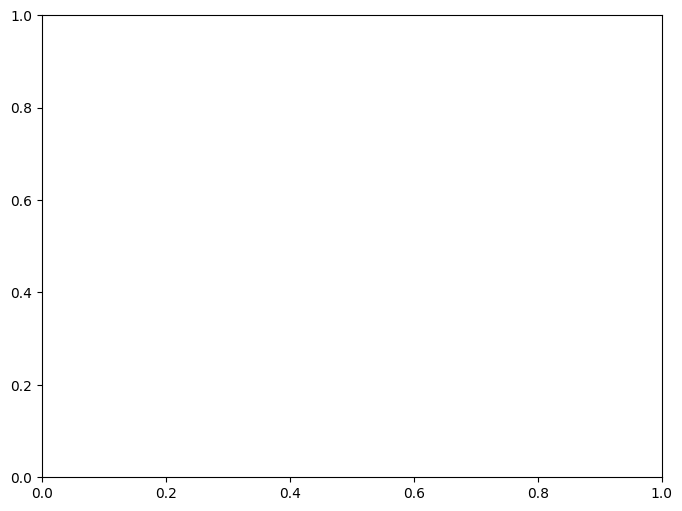

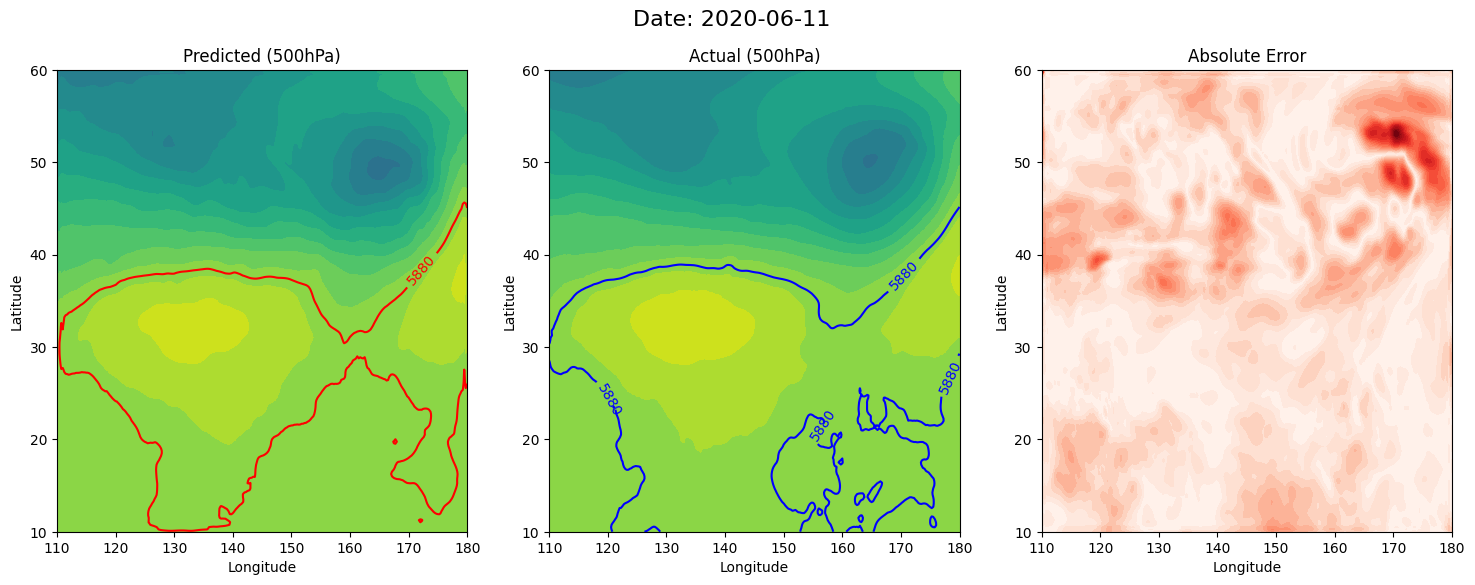

In [ ]:
z = ds['z'].sel(pressure_level=500)
time = ds['valid_time'].values
lat = ds['latitude'].values
lon = ds['longitude'].values

z = z / 9.80665

fig, ax = plt.subplots(figsize=(8, 6))
lon2d, lat2d = np.meshgrid(lon, lat)

val_time = [pd.to_datetime(str(t)) for t in val_time_raw]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
levels = np.linspace(5300, 6000, 21)
contour_level = [5880]

def update(frame):
    for ax in axes:
        ax.clear()

    pred = pred_list[frame]
    actual = actual_list[frame]
    err = error_list[frame]

    cf0 = axes[0].contourf(lon2d, lat2d, pred, levels=levels, cmap='viridis')
    cl0 = axes[0].contour(lon2d, lat2d, pred, levels=contour_level, colors='red')
    axes[0].clabel(cl0, fmt={5880: '5880'}, colors='red')
    axes[0].set_title("Predicted (500hPa)")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    cf1 = axes[1].contourf(lon2d, lat2d, actual, levels=levels, cmap='viridis')
    cl1 = axes[1].contour(lon2d, lat2d, actual, levels=contour_level, colors='blue')
    axes[1].clabel(cl1, fmt={5880: '5880'}, colors='blue')
    axes[1].set_title("Actual (500hPa)")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    cf2 = axes[2].contourf(lon2d, lat2d, err, levels=20, cmap='Reds')
    axes[2].set_title("Absolute Error")
    axes[2].set_xlabel("Longitude")
    axes[2].set_ylabel("Latitude")

    fig.suptitle(f"Date: {val_time[frame].strftime('%Y-%m-%d')}", fontsize=16)

ani = animation.FuncAnimation(fig, update, frames=len(pred_list), interval=300, blit=False)


In [ ]:
gif_save_path = "yourpath/Convlstm('z','t','u','v','q')  z보정,uv 보정 (iou:0.6737 ) _예측_실제_오차_비교_지도스타일.gif"
ani.save(gif_save_path, writer='pillow', fps=3)

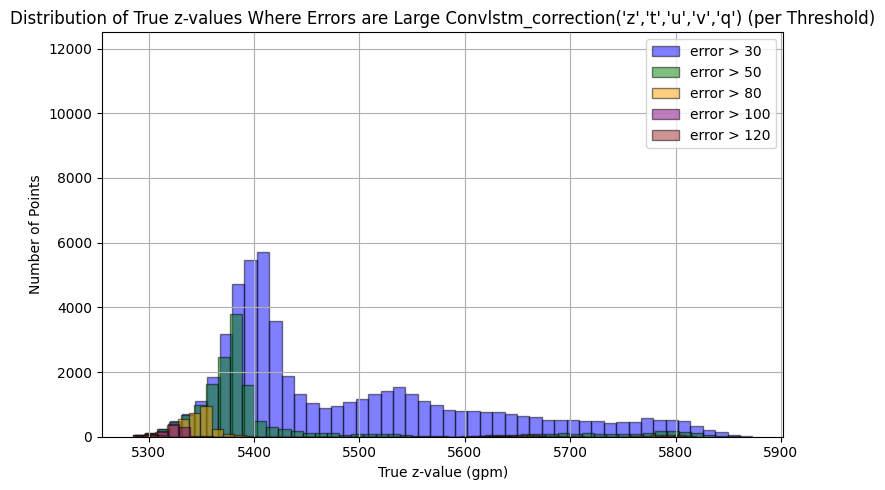

In [ ]:

plt.rcParams['font.family'] = 'DejaVu Sans'

thresholds = [30,50,80,100,120]
z_distributions = {thr: [] for thr in thresholds}

for pred, actual in zip(pred_list, actual_list):
    error = np.abs(pred - actual)
    for thr in thresholds:
        mask = error > thr
        z_vals = actual[mask]
        z_distributions[thr].append(z_vals)

for thr in thresholds:
    z_distributions[thr] = np.concatenate(z_distributions[thr])

plt.figure(figsize=(8, 5))
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'red']

for thr, color in zip(thresholds, colors):
    plt.hist(z_distributions[thr], bins=50, alpha=0.5,
             label=f'error > {thr}', color=color, edgecolor='black')

plt.title("Distribution of True z-values Where Errors are Large Convlstm_correction('z','t','u','v','q') (per Threshold)")
plt.xlabel("True z-value (gpm)")
plt.ylabel("Number of Points")
plt.ylim(0,12500)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install shapely

pred_mask sum: 10768
actual_mask sum: 11540


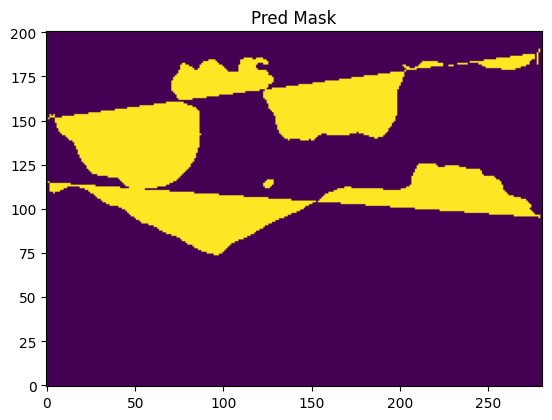

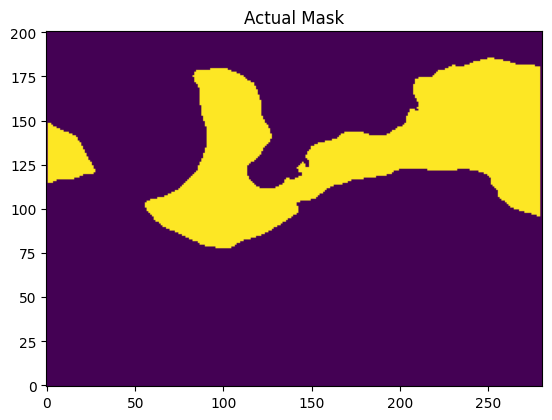

In [ ]:
pred_contours = plt.contour(lon2d, lat2d, pred, levels=[5880])
actual_contours = plt.contour(lon2d, lat2d, actual, levels=[5880])

def create_mask_from_contours(contours, lon2d, lat2d):
    from matplotlib.path import Path

    mask = np.zeros_like(lon2d, dtype=bool)

    for seg in contours:
        path = Path(seg)
        points = np.vstack((lon2d.flatten(), lat2d.flatten())).T
        inside = path.contains_points(points).reshape(lon2d.shape)
        mask |= inside

    return mask

pred_mask = create_mask_from_contours(pred_contours.allsegs[0], lon2d, lat2d)
actual_mask = create_mask_from_contours(actual_contours.allsegs[0], lon2d, lat2d)

print("pred_mask sum:", pred_mask.sum())
print("actual_mask sum:", actual_mask.sum())

plt.imshow(pred_mask, origin='lower')
plt.title("Pred Mask")
plt.show()

plt.imshow(actual_mask, origin='lower')
plt.title("Actual Mask")
plt.show()



In [ ]:
def calculate_iou(pred, actual, lon2d, lat2d, contour_level=5880):
    from matplotlib.path import Path

    pred_contours = plt.contour(lon2d, lat2d, pred, levels=[contour_level])
    actual_contours = plt.contour(lon2d, lat2d, actual, levels=[contour_level])
    plt.close() 

    def create_mask_from_contours(contours, lon2d, lat2d):
        mask = np.zeros_like(lon2d, dtype=bool)
        for seg in contours:
            path = Path(seg)
            points = np.vstack((lon2d.flatten(), lat2d.flatten())).T
            inside = path.contains_points(points).reshape(lon2d.shape)
            mask |= inside
        return mask

    if len(pred_contours.allsegs[0]) == 0 or len(actual_contours.allsegs[0]) == 0:
        return 0.0

    pred_mask = create_mask_from_contours(pred_contours.allsegs[0], lon2d, lat2d)
    actual_mask = create_mask_from_contours(actual_contours.allsegs[0], lon2d, lat2d)

    intersection = np.logical_and(pred_mask, actual_mask).sum()
    union = np.logical_or(pred_mask, actual_mask).sum()

    if union == 0:
        return 0.0

    return intersection / union


In [ ]:
iou_scores = []
val_time_plot = []

for frame in range(len(pred_list)):
    pred = pred_list[frame]
    actual = actual_list[frame]
    iou = calculate_iou(pred, actual, lon2d, lat2d, contour_level=5880)
    iou_scores.append(iou)
    val_time_plot.append(val_time[frame])


for t, iou in zip(val_time, iou_scores):
    print(f"{t.strftime('%Y-%m-%d')}: IOU = {iou:.4f}")


2020-06-11: IOU = 0.0890
2020-06-11: IOU = 0.8174
2020-06-11: IOU = 0.5467
2020-06-11: IOU = 0.8994
2020-06-12: IOU = 0.8654
2020-06-12: IOU = 0.9101
2020-06-12: IOU = 0.8542
2020-06-12: IOU = 0.9253
2020-06-13: IOU = 0.8747
2020-06-13: IOU = 0.7828
2020-06-13: IOU = 0.8512
2020-06-13: IOU = 0.8632
2020-06-14: IOU = 0.7150
2020-06-14: IOU = 0.7720
2020-06-14: IOU = 0.7769
2020-06-14: IOU = 0.8481
2020-06-15: IOU = 0.7359
2020-06-15: IOU = 0.2556
2020-06-15: IOU = 0.3220
2020-06-15: IOU = 0.8868
2020-06-16: IOU = 0.8331
2020-06-16: IOU = 0.8459
2020-06-16: IOU = 0.6621
2020-06-16: IOU = 0.5294
2020-06-17: IOU = 0.7348
2020-06-17: IOU = 0.4220
2020-06-17: IOU = 0.3729
2020-06-17: IOU = 0.3701
2020-06-18: IOU = 0.6954
2020-06-18: IOU = 0.7097
2020-06-18: IOU = 0.5147
2020-06-18: IOU = 0.5636
2020-06-19: IOU = 0.4104
2020-06-19: IOU = 0.6220
2020-06-19: IOU = 0.4696
2020-06-19: IOU = 0.6414
2020-06-20: IOU = 0.4765
2020-06-20: IOU = 0.8056
2020-06-20: IOU = 0.5942
2020-06-20: IOU = 0.8182


평균 IoU (NaN 제외): 0.6737


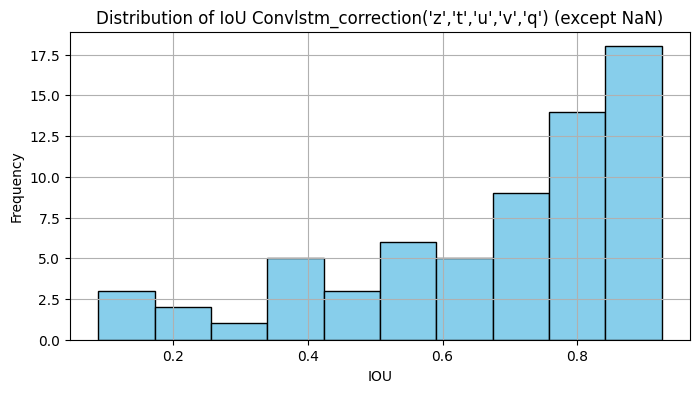

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

valid_ious = [iou for iou in iou_scores if not np.isnan(iou)]

if valid_ious:
    mean_iou = np.mean(valid_ious)
    print(f"평균 IoU (NaN 제외): {mean_iou:.4f}")
else:
    print("유효한 IOU 값이 없습니다.")


plt.figure(figsize=(8, 4))
plt.hist(valid_ious, bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of IoU Convlstm_correction('z','t','u','v','q') (except NaN)")
plt.xlabel("IOU")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


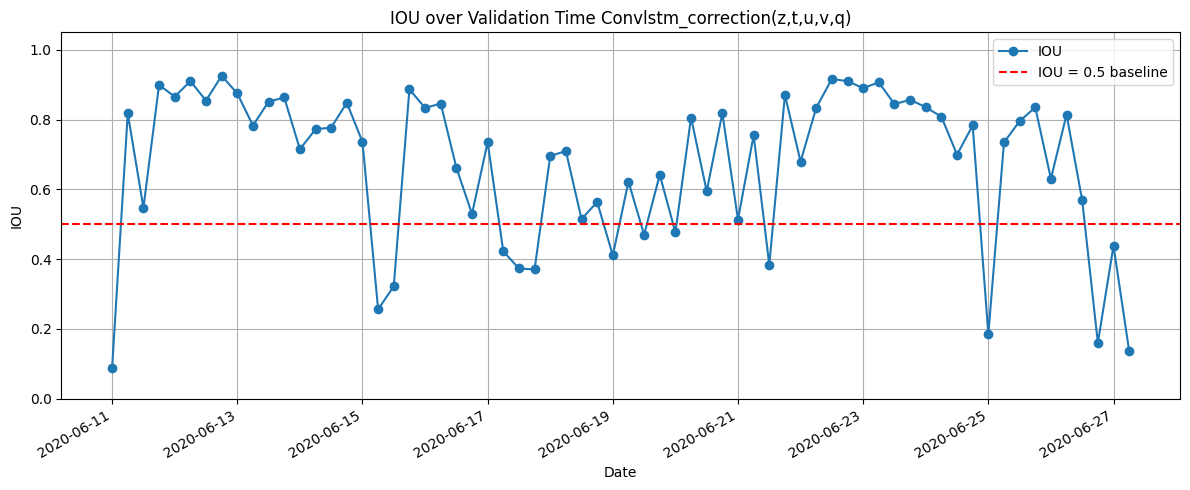

In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 5))
plt.plot(val_time_plot, iou_scores, marker='o', linestyle='-', label='IOU')
plt.axhline(y=0.5, color='r', linestyle='--', label='IOU = 0.5 baseline')

plt.title('IOU over Validation Time Convlstm_correction(z,t,u,v,q)')
plt.xlabel('Date')
plt.ylabel('IOU')
plt.ylim(0, 1.05)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
plt.savefig("yourpath/iou_timeseries_ConvLSTM_z_t_u_v_q_corrected.png", dpi=300)

/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


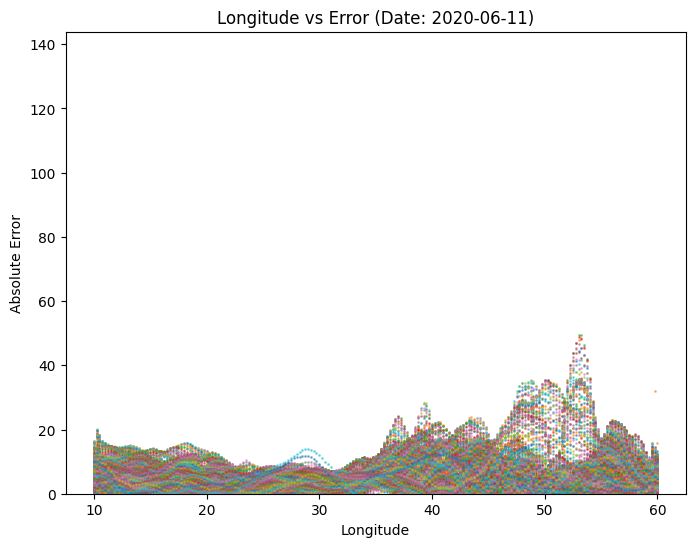

In [ ]:
all_errors = np.stack(error_list)
ymin = all_errors.min()
ymax = all_errors.max()

fig_error, ax_error = plt.subplots(figsize=(8, 6))

def update(frame):
    for ax in axes:
        ax.clear()

    pred = pred_list[frame]
    actual = actual_list[frame]
    err = error_list[frame]


    cf2 = axes[2].contourf(lon2d, lat2d, err, levels=20, cmap='Reds')
    axes[2].set_title("Absolute Error")
    axes[2].set_xlabel("Longitude")
    axes[2].set_ylabel("Latitude")

    ax_error.clear()
    ax_error.set_ylim(ymin, ymax)

    ax_error.set_title(f"Longitude vs Error (Date: {val_time[frame].strftime('%Y-%m-%d')})")
    ax_error.set_xlabel("Longitude")
    ax_error.set_ylabel("Absolute Error")

    for j in range(len(lon)):
         ax_error.plot(lat, err[:, j], '.', alpha=0.5, markersize=2)

    fig.suptitle(f"Date: {val_time[frame].strftime('%Y-%m-%d')}", fontsize=16)

ani_main = animation.FuncAnimation(fig, update, frames=len(pred_list), interval=300, blit=False)
ani_error = animation.FuncAnimation(fig_error, update, frames=len(pred_list), interval=300, blit=False)

In [ ]:
gif_save_path = "yourpath/Convlstm('z','t','u','v','q')z보정,uv보정 iou: 0.6737_산점도-경도.gif"
ani_error.save(gif_save_path, writer='pillow', fps=3)

print("GIF 저장 완료:", gif_save_path)